# CS549 Machine Learning 
# Assignment 5: <br>EigenHand -- An application of principal component analysis (PCA) on image processing

**Total points: 10**

In this assignment, you will implement principal compomnent analysis (PCA) using numpy, and conduct some experiments that are similar to the "EigenFace" study introduced in the class. 

We use the sign language image data. What we are basically doing is to select the image data of one class (e.g., the sign for "zero"), and extract its principal components (PCs). Then we can visualize the data by reducing the dimension to the first 2 most dominant PCs. Also, given a new image, we can use its projections onto the PCs to determine whether it is a sign for "zero" or not.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load data

Load data and preprocess.

The dimension of data $X$ is $n\times m$, in which $n=4096=64\times64$ is the total number of pixels in an image, and $m=163$ is the number of examples.

X shape: (4096, 163)


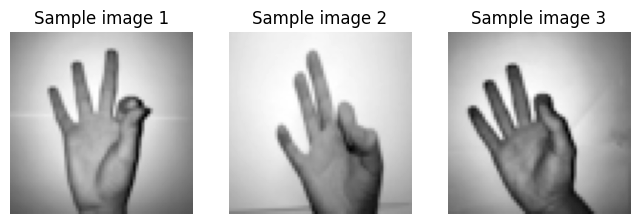

In [3]:
X_all = np.load(open('X_train.npy', 'rb'))
Y_all = np.load(open('Y_train.npy', 'rb'))
# print(X_all.shape)
# print(Y_all.shape)
# print(Y_all[162,]) # y=0
# print(Y_all[163,]) # y=1
# print(Y_all[327,]) # y=2

X_reshape = np.transpose(X_all, (1,2,3,0)).reshape(-1, X_all.shape[0])
X = X_reshape[:, :163]
print('X shape:', X.shape)

# Print some sample images
fig = plt.figure(figsize=(8, 4))
for i, idx in enumerate([0, 50, 100]):
    fig.add_subplot(1, 3, i+1)
    img = X_all[idx,:,:,0]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Sample image {}'.format(i+1))
plt.show()

## Task 1. Centerize data
**1 point**

We need to centerize the data by subtracting $X$ from the mean values of each row. I.e., for each $i,j$, $X[i,j]=mean(X[i,:])$.

This step is necessary before carrying out PCA. You may notice that in the slides we do a further normalization by dividing by the standard deviation after subtracting the means. In this homework, we do not use the divding step for the convenience of later reconstruction steps. Fortunately, not fullly normalizing the data will not harm PCA of image data.

**Instructions:**
- You can use `np.mean()` to compute the mean of each row, with argument `axis=1`
- The result of computing `np.mean` on $X$ (of shape (n, m)) could be (n,), and that means you may need to reshape it to (n,1) before subtracting it from $X$.

In [4]:
# Complete the code and run it to evaluate

### START YOUR CODE ###
X_tilde = X - np.mean(X, axis=1, keepdims=True)
### END YOUR CODE ###

assert X.shape == X_tilde.shape
print('Shape of the centerized data:', X_tilde.shape)
print('First 5 elements of first row in X_tilde:', X_tilde[0,:5])
print('First 5 elements of last row in X_tilde:', X_tilde[-1,:5])

Shape of the centerized data: (4096, 163)
First 5 elements of first row in X_tilde: [-0.01975209 -0.01583052  0.2939734   0.32534593 -0.0432815 ]
First 5 elements of last row in X_tilde: [-0.06082091  0.01761046  0.08427715  0.23329675  0.00192419]


### Expected output

**Shape of the centerized data:** (4096, 163)
**First 5 elements of first row in X_tilde:**[-0.01975209 -0.01583052  0.2939734   0.32534593 -0.0432815 ]
**First 5 elements of last row in X_tilde:**[-0.06082091  0.01761046  0.08427715  0.23329675  0.00192419]

***

## Task 2. Construct covariance matrix and compute eigenvectors
**5 points**

The principal components of data can be obtained by computing the eigenvectors $u_i$ of the covariance matrix $\frac{1}{m}\tilde{X}\tilde{X}^{T}$.

However, the shape of $\frac{1}{m}\tilde{X}\tilde{X}^{T}$ is $n\times n$, and it will be slow to carry out eigen decomposition when $n$ is big (In our case, $n=64\times 64=4096$). Therefore, we need to use an alternative way.

The **solution** is that we first compute the eigenvectors $u'_i$ of the matrix $\frac{1}{m}\tilde{X}^{T}\tilde{X}$ (of shape $m\times m$), which satisfy the following equation:


\begin{equation}
\big(\frac{1}{m}\tilde{X}^{T}\tilde{X}\big)u'_i = \lambda_i u'_i
\end{equation}


where $\lambda_i$ is the correponding non-zero eigenvalue. Note that $\lambda_i/\sum{\lambda_i}$ measures the proportion of variance that the $i$th principal component explains.
Because in our case $m=163$ is much smaller than $n=4096$, the computation for $u'_i$ is much faster. Then we can compute the eigenvectors of $\frac{1}{m}\tilde{X}\tilde{X}^{T}$ by: $u_i = \tilde{X}u'_i$. This is valid because of the following:

\begin{equation}
\big(\frac{1}{m}\tilde{X}^{T}\tilde{X}\big)u'_i = \lambda_i u'_i \Longrightarrow \tilde{X}\big(\frac{1}{m}\tilde{X}^{T}\tilde{X}\big)u'_i = \tilde{X}\lambda_i u'_i \Longrightarrow \big(\frac{1}{m}\tilde{X}\tilde{X}^{T}\big)(\tilde{X}u'_i) = \lambda_i (\tilde{X}u'_i)
\end{equation}

Of course we need to normalize $u_i$ by $u_i = \frac{u_i}{||u_i||}$, so that it satisfy the $||u||=1$ constraint of principal components.

**Instructions:**
- You can compute the eigenvectors of a $m\times m$ matrix by calling `numpy.linalg.eig()`. It returns two numpy arrays `w` and `v`, among which `w` contains $m$ eigenvalues, and `v` is a $m\times m$ array whose ith column `v[:,i]` is the corresponding eigenvector of `w[i]`  
- You can normalize a vector by calling `numpy.linalg.norm()`

PC1 explains 0.14315782487392426% of the total variance
PC2 explains 0.07078766077756882% of the total variance
First 100 PCs explains 0.9473924844294017% of the total variance

Shape of U: (4096, 163)
First 5 elements of first column of U: [0.03381537 0.03353881 0.03292298 0.03238798 0.03146345]
First 5 elements of last column of U: [0.00672679 0.00496044 0.0067214  0.00759421 0.00543667]


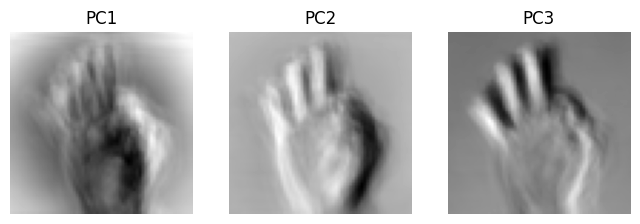

In [56]:
# Complete the code and run it to evaluate

### START YOUR CODE ###
# Construct the covariance matrix for computing u'_i
covmat = (1/163) * np.dot(X_tilde.T, X_tilde)

# Compute u'_i, which is stored in the variable v
w, v = np.linalg.eig(covmat)

# Compute u_i from u'_i, and store it in the variable U
U = np.dot(X_tilde, v)

# Normalize u_i, i.e., each column of U
U = U / np.linalg.norm(U, axis=0)
### END YOUR CODE ###


# Evaluate eigenvalues
ratios = w / np.sum(w)
print('PC1 explains {}% of the total variance'.format(ratios[0]))
print('PC2 explains {}% of the total variance'.format(ratios[1]))
print('First 100 PCs explains {}% of the total variance'.format(sum(ratios[:100])))
print()

# Evaluate U
print('Shape of U:', U.shape)
print('First 5 elements of first column of U:', U[:5,0])
print('First 5 elements of last column of U:', U[:5,-1])

# Plot eigenvectors as if they are image data, i.e., eigenhands
fig = plt.figure(figsize=(8, 4))
for i in range(3):
    img = U[:, i].reshape((64, 64))
    fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('PC' + str(i+1))
plt.show()

### Expected output

PC1 explains 14.32% of the total variance
PC2 explains 7.08% of the total variance
First 100 PCs explains 94.84% of the total variance

**Shape of U:** (4096, 163)
**First 5 elements of first column of U:**[0.03381537 0.03353881 0.03292298 0.03238798 0.03146345]
**First 5 elements of last column of U:**[-0.00672667 -0.00496044 -0.00672151 -0.00759426 -0.00543667]

<img src="eigenhands.png">

***


## Task 3. Reduce dimension and visualize
**1 point**

After we have obtained all the principal components, we can conduct dimensionality reduction by project the original data to a selected set of PCs. For visualization purpose, we select the top two PCs, and reduce the data to a 2-D space.

Let $u_1$ and $u_2$ the 1st and 2nd columns of matrix `U`, the projection of an image data $\tilde{x}$ (already centerized) can be done by computing the inner products $y_1 = u_1^T\tilde{x}$ and $y_2 = u_2^T\tilde{x}$. Then you can visualize the data using the scatter plot of $y_1$ and $y_2$.

**Instructions:**
- Select the first two PCs by `U[:,:2]`, and then use `numpy.dot()` to compute the inner product with $\tilde{X}$.
- `Y` is of shape $2\times m$.

Shape of Y: (2, 163)
First 5 elements of first row of Y: [-0.89141905  0.4688379   6.0011134   7.3501973   1.0118954 ]
First 5 elements of second row of Y: [-0.8475753 -1.0585912  5.871909   1.2650034 -3.0990107]


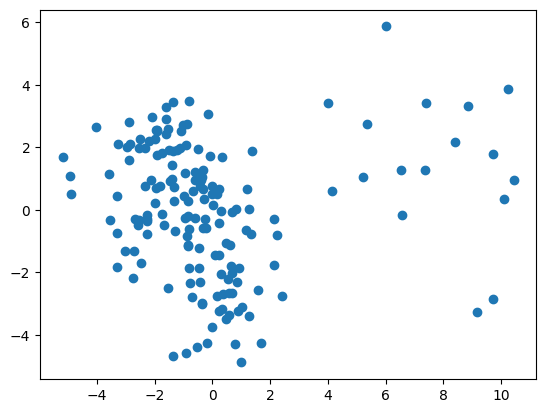

In [51]:
# Complete the code and run it to evaluate

### START YOUR CODE ###
Y = np.dot(U[:, :2].T, X_tilde)
### END YOUR CODE ###


print('Shape of Y:', Y.shape)
print('First 5 elements of first row of Y:', Y[0,:5])
print('First 5 elements of second row of Y:', Y[1,:5])

fig = plt.figure()
plt.scatter(Y[0,:], Y[1,:])
plt.show()

### Expected output

**Shape of Y:**(2, 163)
**First 5 elements of first row of Y:**[-0.89141893  0.46883804  6.0011144   7.3501954   1.0118954 ]
**First 5 elements of second row of Y:**[ 0.8475754  1.0585912 -5.8719096 -1.2650039  3.09901  ]

<img src="2d_new.png">

***

## Task 4. Project and reconstruct
**3 points**

We can not only project data onto principal components to reduce dimensions, but also use the projections to reconstruct data. 

Let $\tilde{x}$ be the original data, and its projections on the first $k$ PCs are: $p_1 = u_1^T\tilde{x},p_2 = u_2^T\tilde{x},\dots,p_k = u_k^T\tilde{x}$. Then we can have the reconstruction of data $\tilde{x}'$ by:

\begin{equation}
\tilde{x}' = p_1\cdot u_1 + p_2\cdot u_2 + \dots + p_k\cdot u_k
\end{equation}

If the full set of PCs are used, then the reconstruction will be perfect, i.e., exactly the same as the original image without losing any informaiton. If a subset (e.g., top $k$ PCs) is used, then the reconstruction will cause some information loss. 

This information loss can be measured by the Euclidean distance between the original data $\tilde{x}$ and the reconstruted data $\tilde{x}'$. Larger distance indicates higher information loss.

**Instructions:**
- Use `numpy.dot()` to compute projections and reconstructions.
- Use `numpy.linalg.norm()` to compute distance.

In [52]:
# Project and reconstruct
def project_reconstruct(X, U, num_dims):
    """
    Args:
    X -- centerized image data, of shape (n, m)
    U -- numpy array containing principal components, of shape (n, m)
    num_dims -- the number of PCs upon which to project X.
    
    Return:
    X_proj -- projections on the top num_dims PCs, of shape (num_dims, m)
    X_recon -- reconstructed data, of shape (n, m)
    dist -- Euclidean distance between X and X_recon, of shape (m,)
    """
    assert num_dims <= U.shape[1]
    assert X.shape[0] == U.shape[0]
    
    ### START YOUR CODE ###
    X_proj = U[:, :num_dims].T @ X
    X_recon = U[:, :num_dims] @ X_proj
    dist = np.linalg.norm(X - X_recon, axis=0)
    ### END YOUR CODE ###
    
    return X_proj, X_recon, dist

Mean distance of reconstruction using 163 PCs: 0.0060058110393583775
Mean distance of reconstruction using 100 PCs: 1.8153880834579468
Mean distance of reconstruction using 50 PCs: 3.2072253227233887


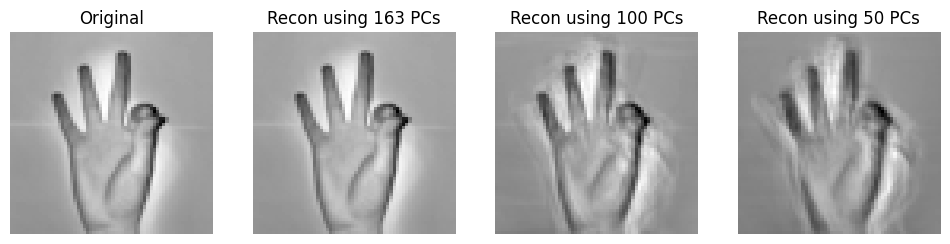

In [53]:
# Test code. Do not change the code below
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 4, 1)
img_orig = X_tilde[:,0].reshape((64, 64))
plt.imshow(img_orig, cmap='gray')
plt.axis('off')
plt.title('Original')

for i, num_dims in enumerate([163, 100, 50]):
    X_proj, X_recon, dist = project_reconstruct(X_tilde, U, num_dims)
    print('Mean distance of reconstruction using {} PCs: {}'.format(num_dims, np.mean(dist)))
    
    fig.add_subplot(1, 4, i+2)
    img_recon = X_recon[:,0].reshape((64, 64))
    plt.imshow(img_recon, cmap='gray')
    plt.axis('off')
    plt.title('Recon using {} PCs'.format(num_dims))
    
plt.show()

### Expected output

**Mean distance of reconstruction using 163 PCs:** 0.00334941572509706
**Mean distance of reconstruction using 100 PCs:** 1.7380056381225586
**Mean distance of reconstruction using 50 PCs:** 3.1700222492218018

<img src="reconstruction.png">

***

## New image detection (Ungraded)

Given a new image of the sign for a different number, if we project it onto the PCs that we extracted above, then the reconstruction distance will be very large, and the reconstructed image will not likely be recognizable. This is because the principal components summarize current image class well, but not apply to images of different classes. 

This is also how PCA can be used in applications such as face detection etc.

Reconstruction distance for out-of-class data: 5.432931


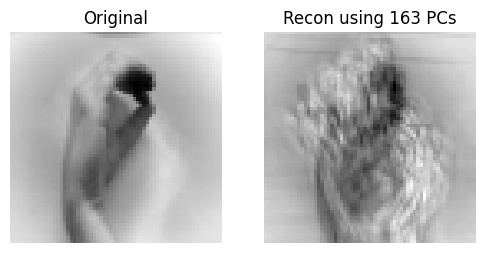

In [54]:
# Project and reconstruct one instance of new data
x_new = X_reshape[:, 163]
x_new_tilde = x_new - np.mean(X, axis=1)

_, x_new_recon, dist = project_reconstruct(x_new_tilde, U, 163)
print('Reconstruction distance for out-of-class data:', dist)

# Plot
fig = plt.figure(figsize=(6, 3))

fig.add_subplot(1, 2, 1)
img_orig = x_new_tilde.reshape((64, 64))
plt.imshow(img_orig, cmap='gray')
plt.axis('off')
plt.title('Original')

fig.add_subplot(1, 2, 2)
img_recon = x_new_recon.reshape((64, 64))
plt.imshow(img_recon, cmap='gray')
plt.axis('off')
plt.title('Recon using 163 PCs')

plt.show()